In [ ]:
# Mount Google Drive to access data and save models
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


DATASETBENER1 : konsep awal (jalan, tepi kanan/kiri, percabangan);
DATASETBENER2 : jalan, tepi, percabangan ;
DATASETBENER3 : jalan, tepi (percabangan jadi jalan) ;
DATASETBENER4 : jalan, tepi (percabangan jadi tepikiri) ;
DATASETBENER5 : jalan, tepi kanan/kiri (percabangan jadi tepi kiri) ;

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Is GPU available: True
Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading training data...
Loading classes from /content/drive/MyDrive/datasetbener1/train/_classes.csv...
Loaded class mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Loading validation data...
Loading classes from /content/drive/MyDrive/datasetbener1/valid/_classes.csv...
Loaded class mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Building the model...
Training the model...
Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.6526 - loss: 0.9382 - val_accuracy: 0.9201 - val_loss: 0.3067
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9139 - loss: 0.3116 - val_accuracy: 0.9263 - val_loss: 0.2646
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.9217 - loss: 0.2712 - val_accuracy: 0.9403 - val_loss: 0.2005
Epoch 4/50
196/19

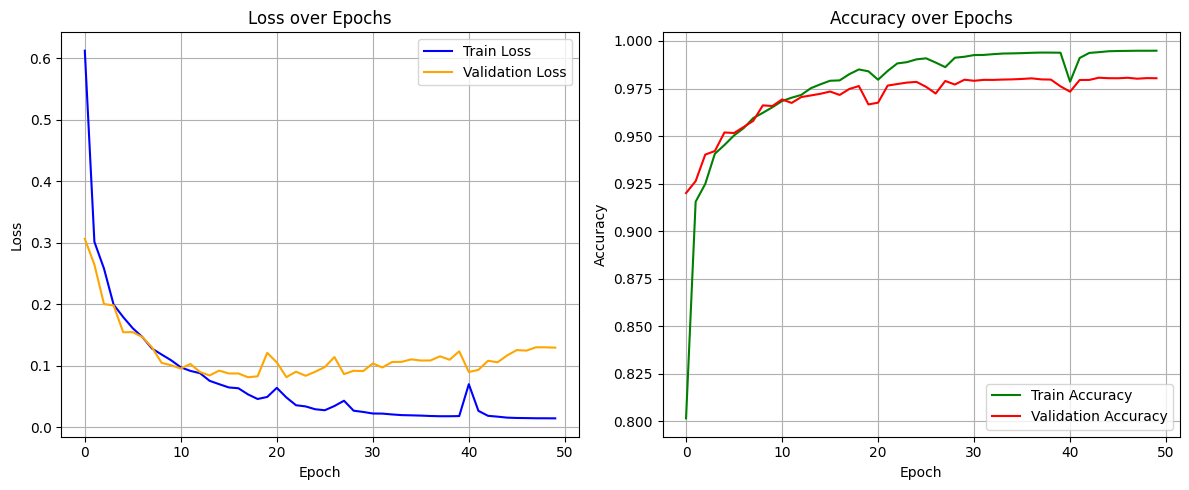

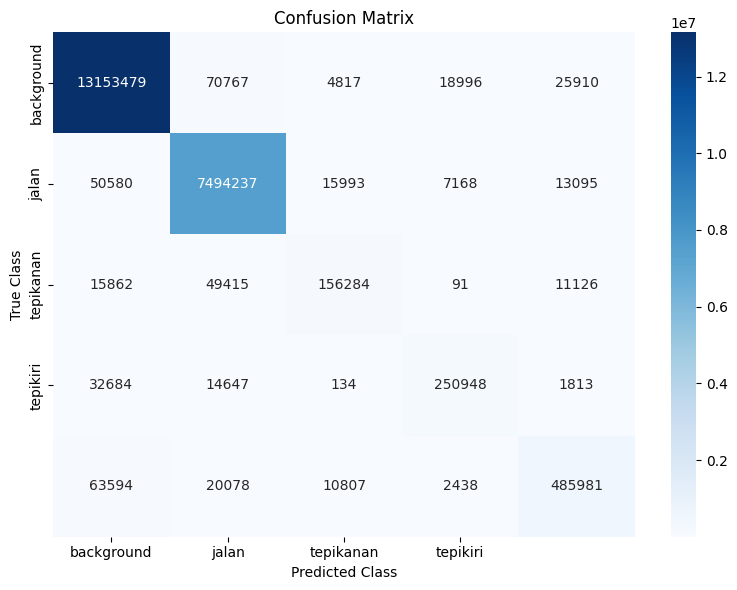

In [ ]:
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score

drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import os
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Verifikasi GPU
print("Is GPU available:", tf.test.is_gpu_available())
print("Available GPU:", tf.config.list_physical_devices('GPU'))

# Define paths and parameters
base_dir = '/content/drive/MyDrive/datasetbener1'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')

img_height, img_width = 288, 512
batch_size = 8
learning_rate = 0.0001
epochs = 50
early_stop_patience = 10

# Function to load class mapping from _classes.csv in a specific folder
def load_classes(folder):
    classes_file = os.path.join(folder, '_classes.csv')
    print(f"Loading classes from {classes_file}...")
    df = pd.read_csv(classes_file)

    # Handle column names dynamically
    pixel_col = [col for col in df.columns if 'Pixel' in col][0]
    class_col = [col for col in df.columns if 'Class' in col][0]

    # Ensure proper mapping
    class_mapping = {}
    for _, row in df.iterrows():
        pixel_value = int(row[pixel_col])
        class_name = row[class_col].strip()
        class_mapping[pixel_value] = len(class_mapping)

    print(f"Loaded class mapping: {class_mapping}")
    return class_mapping

# Function to load and preprocess data
def load_data(folder):
    class_mapping = load_classes(folder)
    images, masks = [], []

    for file_name in os.listdir(folder):
        if file_name.endswith('.jpg'):
            img_path = os.path.join(folder, file_name)
            mask_path = os.path.join(folder, file_name.replace('.jpg', '_mask.png'))

            # Load and normalize the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Load the mask
            mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(img_height, img_width), color_mode='grayscale')
            mask = tf.keras.preprocessing.image.img_to_array(mask).astype(np.uint8).squeeze()

            # Normalize mask pixel values to class indices
            for pixel_value, class_idx in class_mapping.items():
                mask[mask == pixel_value] = class_idx
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)  # Expand dimensions for compatibility
    return images, masks, len(class_mapping)

# Load training and validation data
print("Loading training data...")
train_images, train_masks, num_classes_train = load_data(train_dir)
print("Loading validation data...")
val_images, val_masks, num_classes_val = load_data(val_dir)

if num_classes_train != num_classes_val:
    raise ValueError("The number of classes in training and validation datasets are not the same.")

num_classes = num_classes_train

# Define U-Net model
def unet_model(input_size=(img_height, img_width, 3), num_classes=num_classes):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
print("Building the model...")
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/datasetbener1/best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stop_patience, mode='max', verbose=1)

# Train the model
print("Training the model...")
history = model.fit(train_images, train_masks,
                    validation_data=(val_images, val_masks),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpoint, early_stopping])

# Evaluate precision, recall, and F1-score
def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

print("Evaluating the model on validation set...")
val_preds = model.predict(val_images, batch_size=batch_size)
val_preds = np.argmax(val_preds, axis=-1)
precision, recall, f1 = calculate_metrics(val_masks, val_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Menampilkan hasil akhir validation
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")


# Plot grafik Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot grafik Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Flatten label dan prediksi
y_true_flat = val_masks.flatten()
y_pred_flat = val_preds.flatten()

# Daftar nama kelas
class_names = ['background', 'jalan', 'tepikanan', 'tepikiri']

# Buat confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix dengan nama kelas
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Is GPU available: True
Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading training data...
Loading classes from /content/drive/MyDrive/datasetbener2/train/_classes.csv...
Loaded class mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Loading validation data...
Loading classes from /content/drive/MyDrive/datasetbener2/valid/_classes.csv...
Loaded class mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Building the model...
Training the model...
Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.6857 - loss: 0.8277 - val_accuracy: 0.9195 - val_loss: 0.2941
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 240s 985ms/step - accuracy: 0.9115 - loss: 0.2994 - val_accuracy: 0.9298 - val_loss: 0.2313
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9252 - loss: 0.2413 - val_accuracy: 0.9387 - val_loss: 0.1823
Epoch 4/50
196/196 ━━━━━━━

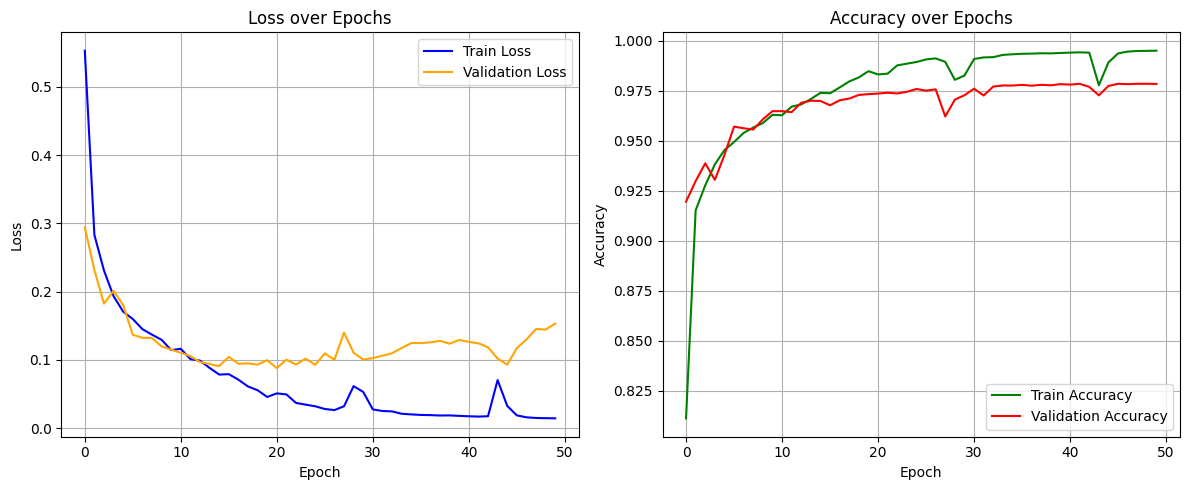

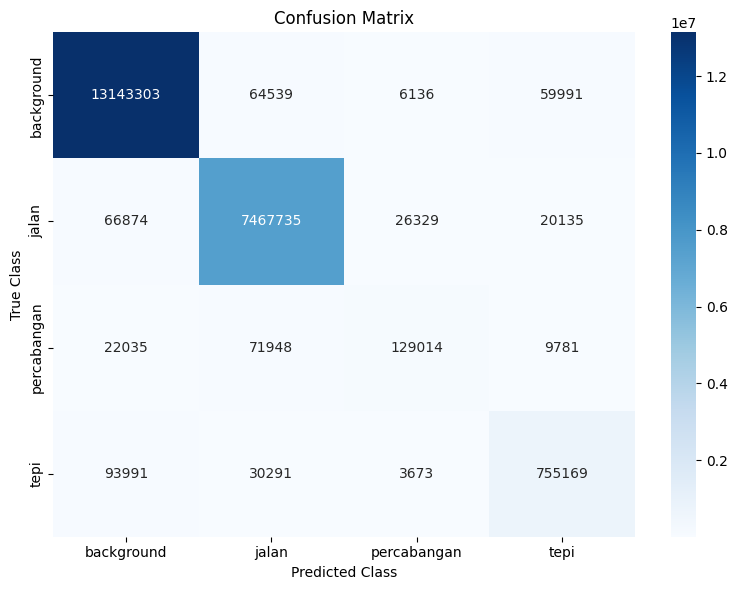

In [ ]:
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score

drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import os
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Verifikasi GPU
print("Is GPU available:", tf.test.is_gpu_available())
print("Available GPU:", tf.config.list_physical_devices('GPU'))

# Define paths and parameters
base_dir = '/content/drive/MyDrive/datasetbener2'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')

img_height, img_width = 288, 512
batch_size = 8
learning_rate = 0.0001
epochs = 50
early_stop_patience = 10

# Function to load class mapping from _classes.csv in a specific folder
def load_classes(folder):
    classes_file = os.path.join(folder, '_classes.csv')
    print(f"Loading classes from {classes_file}...")
    df = pd.read_csv(classes_file)

    # Handle column names dynamically
    pixel_col = [col for col in df.columns if 'Pixel' in col][0]
    class_col = [col for col in df.columns if 'Class' in col][0]

    # Ensure proper mapping
    class_mapping = {}
    for _, row in df.iterrows():
        pixel_value = int(row[pixel_col])
        class_name = row[class_col].strip()
        class_mapping[pixel_value] = len(class_mapping)

    print(f"Loaded class mapping: {class_mapping}")
    return class_mapping

# Function to load and preprocess data
def load_data(folder):
    class_mapping = load_classes(folder)
    images, masks = [], []

    for file_name in os.listdir(folder):
        if file_name.endswith('.jpg'):
            img_path = os.path.join(folder, file_name)
            mask_path = os.path.join(folder, file_name.replace('.jpg', '_mask.png'))

            # Load and normalize the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Load the mask
            mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(img_height, img_width), color_mode='grayscale')
            mask = tf.keras.preprocessing.image.img_to_array(mask).astype(np.uint8).squeeze()

            # Normalize mask pixel values to class indices
            for pixel_value, class_idx in class_mapping.items():
                mask[mask == pixel_value] = class_idx
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)  # Expand dimensions for compatibility
    return images, masks, len(class_mapping)

# Load training and validation data
print("Loading training data...")
train_images, train_masks, num_classes_train = load_data(train_dir)
print("Loading validation data...")
val_images, val_masks, num_classes_val = load_data(val_dir)

if num_classes_train != num_classes_val:
    raise ValueError("The number of classes in training and validation datasets are not the same.")

num_classes = num_classes_train

# Define U-Net model
def unet_model(input_size=(img_height, img_width, 3), num_classes=num_classes):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
print("Building the model...")
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/datasetbener2/best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stop_patience, mode='max', verbose=1)

# Train the model
print("Training the model...")
history = model.fit(train_images, train_masks,
                    validation_data=(val_images, val_masks),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpoint, early_stopping])

# Evaluate precision, recall, and F1-score
def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

print("Evaluating the model on validation set...")
val_preds = model.predict(val_images, batch_size=batch_size)
val_preds = np.argmax(val_preds, axis=-1)
precision, recall, f1 = calculate_metrics(val_masks, val_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Menampilkan hasil akhir validation
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")


# Plot grafik Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot grafik Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Flatten label dan prediksi
y_true_flat = val_masks.flatten()
y_pred_flat = val_preds.flatten()

# Daftar nama kelas
class_names = ['background', 'jalan', 'percabangan', 'tepi']

# Buat confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix dengan nama kelas
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Is GPU available: True
Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading training data...
Loading classes from /content/drive/MyDrive/datasetbener3/train/_classes.csv...
Loaded class mapping: {0: 0, 1: 1, 2: 2}
Loading validation data...
Loading classes from /content/drive/MyDrive/datasetbener3/valid/_classes.csv...
Loaded class mapping: {0: 0, 1: 1, 2: 2}
Building the model...
Training the model...
Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.7106 - loss: 0.7133 - val_accuracy: 0.9280 - val_loss: 0.2324
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 180s 857ms/step - accuracy: 0.9248 - loss: 0.2300 - val_accuracy: 0.9425 - val_loss: 0.1581
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 173s 881ms/step - accuracy: 0.9385 - loss: 0.1798 - val_accuracy: 0.9440 - val_loss: 0.1599
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 168s 856ms/step - accuracy: 0.9452 - loss: 0.1537 - val_accuracy: 0.9575 - val_loss: 0.1219
Epoch 5/50
196/196 ━━━━━━━━━━━━━

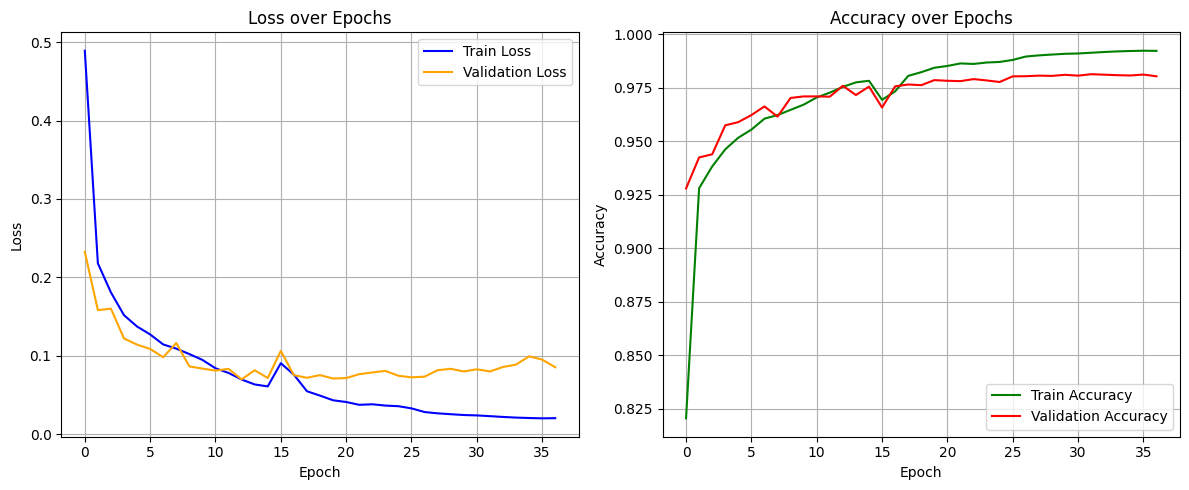

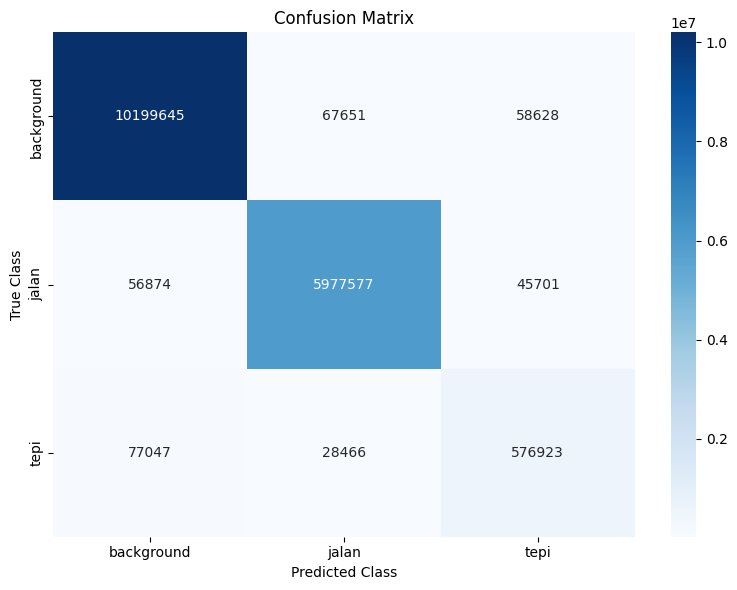

In [ ]:
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score

drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import os
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Verifikasi GPU
print("Is GPU available:", tf.test.is_gpu_available())
print("Available GPU:", tf.config.list_physical_devices('GPU'))

# Define paths and parameters
base_dir = '/content/drive/MyDrive/datasetbener3'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')

img_height, img_width = 256, 448
batch_size = 8
learning_rate = 0.0001
epochs = 50
early_stop_patience = 5

# Function to load class mapping from _classes.csv in a specific folder
def load_classes(folder):
    classes_file = os.path.join(folder, '_classes.csv')
    print(f"Loading classes from {classes_file}...")
    df = pd.read_csv(classes_file)

    # Handle column names dynamically
    pixel_col = [col for col in df.columns if 'Pixel' in col][0]
    class_col = [col for col in df.columns if 'Class' in col][0]

    # Ensure proper mapping
    class_mapping = {}
    for _, row in df.iterrows():
        pixel_value = int(row[pixel_col])
        class_name = row[class_col].strip()
        class_mapping[pixel_value] = len(class_mapping)

    print(f"Loaded class mapping: {class_mapping}")
    return class_mapping

# Function to load and preprocess data
def load_data(folder):
    class_mapping = load_classes(folder)
    images, masks = [], []

    for file_name in os.listdir(folder):
        if file_name.endswith('.jpg'):
            img_path = os.path.join(folder, file_name)
            mask_path = os.path.join(folder, file_name.replace('.jpg', '_mask.png'))

            # Load and normalize the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Load the mask
            mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(img_height, img_width), color_mode='grayscale')
            mask = tf.keras.preprocessing.image.img_to_array(mask).astype(np.uint8).squeeze()

            # Normalize mask pixel values to class indices
            for pixel_value, class_idx in class_mapping.items():
                mask[mask == pixel_value] = class_idx
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)  # Expand dimensions for compatibility
    return images, masks, len(class_mapping)

# Load training and validation data
print("Loading training data...")
train_images, train_masks, num_classes_train = load_data(train_dir)
print("Loading validation data...")
val_images, val_masks, num_classes_val = load_data(val_dir)

if num_classes_train != num_classes_val:
    raise ValueError("The number of classes in training and validation datasets are not the same.")

num_classes = num_classes_train

# Define U-Net model
def unet_model(input_size=(img_height, img_width, 3), num_classes=num_classes):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
print("Building the model...")
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/datasetbener3/datasetbener3coba.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stop_patience, mode='max', verbose=1)

# Train the model
print("Training the model...")
history = model.fit(train_images, train_masks,
                    validation_data=(val_images, val_masks),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpoint, early_stopping])

# Evaluate precision, recall, and F1-score
def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

print("Evaluating the model on validation set...")
val_preds = model.predict(val_images, batch_size=batch_size)
val_preds = np.argmax(val_preds, axis=-1)
precision, recall, f1 = calculate_metrics(val_masks, val_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Menampilkan hasil akhir validation
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")


# Plot grafik Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot grafik Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Flatten label dan prediksi
y_true_flat = val_masks.flatten()
y_pred_flat = val_preds.flatten()

# Daftar nama kelas
class_names = ['background', 'jalan', 'tepi']

# Buat confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix dengan nama kelas
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score

drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import os
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Verifikasi GPU
print("Is GPU available:", tf.test.is_gpu_available())
print("Available GPU:", tf.config.list_physical_devices('GPU'))

# Define paths and parameters
base_dir = '/content/drive/MyDrive/datasetbener3'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')

img_height, img_width = 256, 448  # Resize to smaller size
batch_size = 8
learning_rate = 0.0001
epochs = 50
early_stop_patience = 10

# Function to load class mapping from _classes.csv in a specific folder
def load_classes(folder):
    classes_file = os.path.join(folder, '_classes.csv')
    print(f"Loading classes from {classes_file}...")
    df = pd.read_csv(classes_file)

    # Handle column names dynamically
    pixel_col = [col for col in df.columns if 'Pixel' in col][0]
    class_col = [col for col in df.columns if 'Class' in col][0]

    # Ensure proper mapping
    class_mapping = {}
    for _, row in df.iterrows():
        pixel_value = int(row[pixel_col])
        class_name = row[class_col].strip()
        class_mapping[pixel_value] = len(class_mapping)

    print(f"Loaded class mapping: {class_mapping}")
    return class_mapping

# Function to load and preprocess data
def load_data(folder):
    class_mapping = load_classes(folder)
    images, masks = [], []

    for file_name in os.listdir(folder):
        if file_name.endswith('.jpg'):
            img_path = os.path.join(folder, file_name)
            mask_path = os.path.join(folder, file_name.replace('.jpg', '_mask.png'))

            # Load and normalize the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Load the mask
            mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(img_height, img_width), color_mode='grayscale')
            mask = tf.keras.preprocessing.image.img_to_array(mask).astype(np.uint8).squeeze()

            # Normalize mask pixel values to class indices
            for pixel_value, class_idx in class_mapping.items():
                mask[mask == pixel_value] = class_idx
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)  # Expand dimensions for compatibility
    return images, masks, len(class_mapping)

# Load training and validation data
print("Loading training data...")
train_images, train_masks, num_classes_train = load_data(train_dir)
print("Loading validation data...")
val_images, val_masks, num_classes_val = load_data(val_dir)

if num_classes_train != num_classes_val:
    raise ValueError("The number of classes in training and validation datasets are not the same.")

num_classes = num_classes_train

# Define U-Net model with a lighter encoder
def unet_light(input_size=(256, 448, 3), num_classes=3):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
print("Building the model...")
model = unet_light(input_size=(256, 448, 3), num_classes=num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/datasetbener3/datasetbenertiga.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stop_patience, mode='max', verbose=1)

# Train the model
print("Training the model...")
history = model.fit(train_images, train_masks,
                    validation_data=(val_images, val_masks),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpoint, early_stopping])

# Evaluate precision, recall, and F1-score
def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

print("Evaluating the model on validation set...")
val_preds = model.predict(val_images, batch_size=batch_size)
val_preds = np.argmax(val_preds, axis=-1)
precision, recall, f1 = calculate_metrics(val_masks, val_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Menampilkan hasil akhir validation
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Plot grafik Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot grafik Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Flatten label dan prediksi
y_true_flat = val_masks.flatten()
y_pred_flat = val_preds.flatten()

# Daftar nama kelas
class_names = ['background', 'jalan', 'tepi']

# Buat confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix dengan nama kelas
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()


Mounted at /content/drive


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Is GPU available: True
Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading training data...
Loading classes from /content/drive/MyDrive/datasetbener5/train/_classes.csv...
Loaded class mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Loading validation data...
Loading classes from /content/drive/MyDrive/datasetbener5/valid/_classes.csv...
Loaded class mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Building the model...
Training the model...
Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.8004 - loss: 0.7244 - val_accuracy: 0.9418 - val_loss: 0.1994
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 177s 629ms/step - accuracy: 0.9471 - loss: 0.1807 - val_accuracy: 0.9511 - val_loss: 0.1604
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 141s 626ms/step - accuracy: 0.9567 - loss: 0.1372 - val_accuracy: 0.9595 - val_loss: 0.1183
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 144s 635ms/step - accuracy: 0.9603 - loss: 0.1184 - val_accuracy: 0.9660 - val_loss: 0.0984
Epoch 5/50
196/196 ━

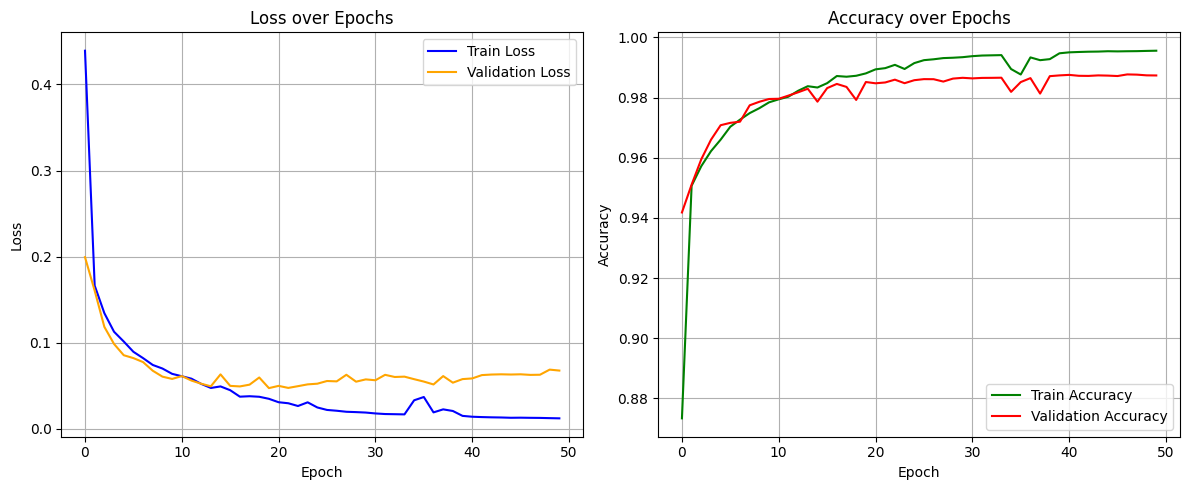

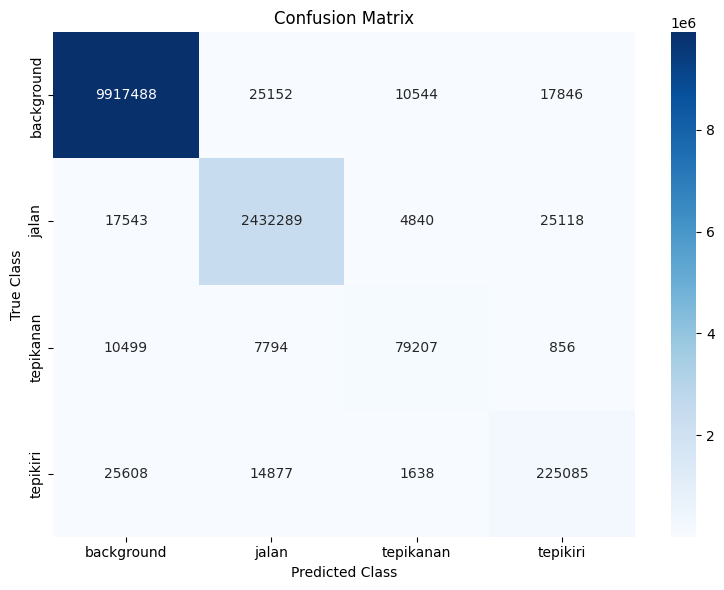

In [ ]:
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score

drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import os
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Verifikasi GPU
print("Is GPU available:", tf.test.is_gpu_available())
print("Available GPU:", tf.config.list_physical_devices('GPU'))

# Define paths and parameters
base_dir = '/content/drive/MyDrive/datasetbener5'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')

img_height, img_width = 224, 384
batch_size = 8
learning_rate = 0.0001
epochs = 50
early_stop_patience = 10

# Function to load class mapping from _classes.csv in a specific folder
def load_classes(folder):
    classes_file = os.path.join(folder, '_classes.csv')
    print(f"Loading classes from {classes_file}...")
    df = pd.read_csv(classes_file)

    # Handle column names dynamically
    pixel_col = [col for col in df.columns if 'Pixel' in col][0]
    class_col = [col for col in df.columns if 'Class' in col][0]

    # Ensure proper mapping
    class_mapping = {}
    for _, row in df.iterrows():
        pixel_value = int(row[pixel_col])
        class_name = row[class_col].strip()
        class_mapping[pixel_value] = len(class_mapping)

    print(f"Loaded class mapping: {class_mapping}")
    return class_mapping

# Function to load and preprocess data
def load_data(folder):
    class_mapping = load_classes(folder)
    images, masks = [], []

    for file_name in os.listdir(folder):
        if file_name.endswith('.jpg'):
            img_path = os.path.join(folder, file_name)
            mask_path = os.path.join(folder, file_name.replace('.jpg', '_mask.png'))

            # Load and normalize the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Load the mask
            mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(img_height, img_width), color_mode='grayscale')
            mask = tf.keras.preprocessing.image.img_to_array(mask).astype(np.uint8).squeeze()

            # Normalize mask pixel values to class indices
            for pixel_value, class_idx in class_mapping.items():
                mask[mask == pixel_value] = class_idx
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)  # Expand dimensions for compatibility
    return images, masks, len(class_mapping)

# Load training and validation data
print("Loading training data...")
train_images, train_masks, num_classes_train = load_data(train_dir)
print("Loading validation data...")
val_images, val_masks, num_classes_val = load_data(val_dir)

if num_classes_train != num_classes_val:
    raise ValueError("The number of classes in training and validation datasets are not the same.")

num_classes = num_classes_train

# Define U-Net model
def unet_model(input_size=(img_height, img_width, 3), num_classes=num_classes):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
print("Building the model...")
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/datasetbener5/best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stop_patience, mode='max', verbose=1)

# Train the model
print("Training the model...")
history = model.fit(train_images, train_masks,
                    validation_data=(val_images, val_masks),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpoint, early_stopping])

# Evaluate precision, recall, and F1-score
def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

print("Evaluating the model on validation set...")
val_preds = model.predict(val_images, batch_size=batch_size)
val_preds = np.argmax(val_preds, axis=-1)
precision, recall, f1 = calculate_metrics(val_masks, val_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Menampilkan hasil akhir validation
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")


# Plot grafik Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot grafik Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Flatten label dan prediksi
y_true_flat = val_masks.flatten()
y_pred_flat = val_preds.flatten()

# Daftar nama kelas
class_names = ['background', 'jalan', 'tepikanan', 'tepikiri']

# Buat confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix dengan nama kelas
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

Loading the best model...
Preprocessing test image...
Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
Visualizing result...


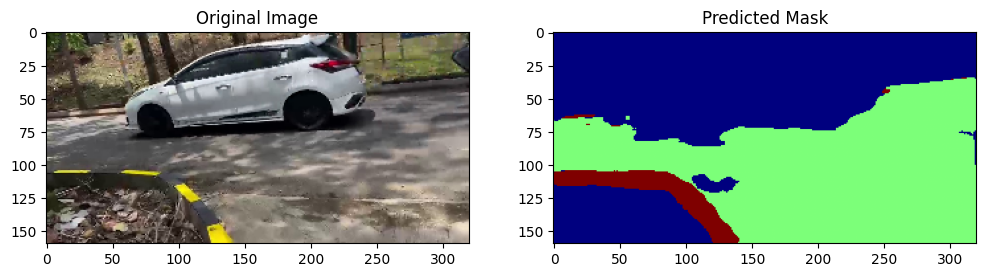

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Path to the test image and model
test_image_path = '/content/drive/MyDrive/datasetsegmentasiniya/image/image_2.jpg'  # Update with your test image path
best_model_path = '/content/drive/MyDrive/datasetbener3/datasetbenertiga.keras'

# Redefine global parameters
img_height, img_width = 160, 320
batch_size = 8  # Match with training batch size

# Load the trained model
print("Loading the best model...")
model = tf.keras.models.load_model(best_model_path)

# Load and preprocess the test image
def preprocess_image(image_path, target_size):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    return np.expand_dims(image_array, axis=0), image_array  # Add batch dimension and return original image for visualization

# Preprocess the test image
print("Preprocessing test image...")
input_image, original_image = preprocess_image(test_image_path, (img_height, img_width))

# Run prediction
print("Running prediction...")
prediction = model.predict(input_image)
predicted_mask = np.argmax(prediction[0], axis=-1)  # Convert probabilities to class indices

# Visualize the result
def visualize_result(original_image, predicted_mask):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='jet')  # Using colormap for better visualization

    plt.show()

print("Visualizing result...")
visualize_result(original_image, predicted_mask)

#merah jalan, biru muda trotoar, biru tua base, kuning belok, ijo tanjak


Loading the best model...
Preprocessing test image and mask...
Running prediction...


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Pixel-wise Accuracy: 0.9828
Visualizing result...


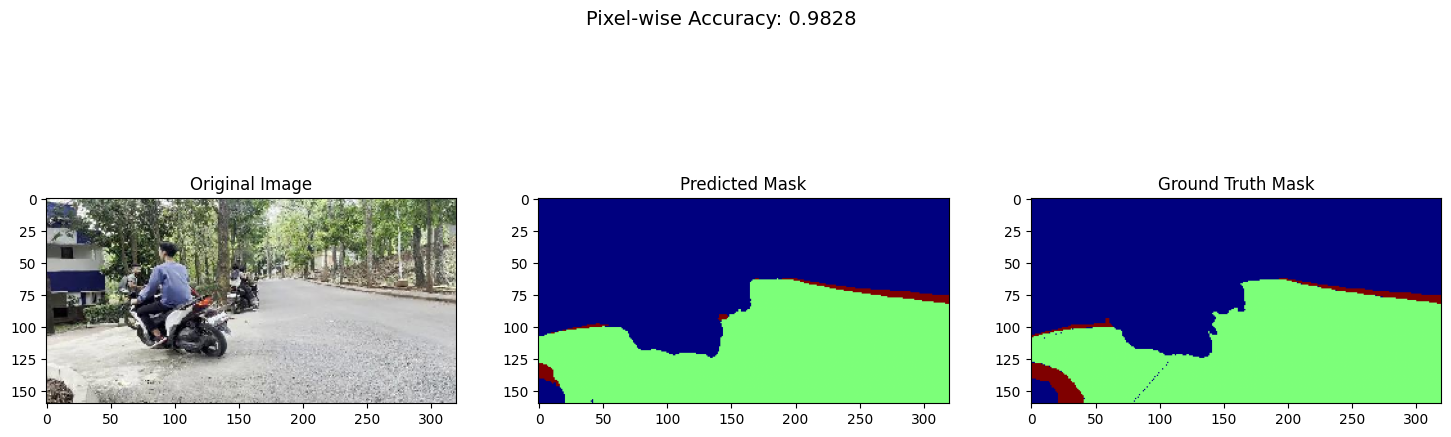

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Path ke image & mask
test_image_path = '/content/drive/MyDrive/datasetbener3/test/image_1035_jpg.rf.21f1370a2a2ac3194952f3f24ac0b400.jpg'
ground_truth_path = '/content/drive/MyDrive/datasetbener3/test/image_1035_jpg.rf.21f1370a2a2ac3194952f3f24ac0b400_mask.png'  # <- sesuaikan path mask
best_model_path = '/content/drive/MyDrive/datasetbener3/model1.keras'

# Parameter ukuran
img_height, img_width = 160, 320
num_classes = 3  # Ganti jika jumlah kelas berbeda

# Load model
print("Loading the best model...")
model = tf.keras.models.load_model(best_model_path)

# Fungsi preprocessing image
def preprocess_image(image_path, target_size):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    return np.expand_dims(image_array, axis=0), image_array

# Fungsi preprocessing mask
def preprocess_mask(mask_path, target_size):
    mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=target_size, color_mode='grayscale')
    mask_array = tf.keras.preprocessing.image.img_to_array(mask).astype(np.uint8)
    mask_array = np.squeeze(mask_array, axis=-1)  # (H, W)
    return mask_array

# Preprocess image & mask
print("Preprocessing test image and mask...")
input_image, original_image = preprocess_image(test_image_path, (img_height, img_width))
ground_truth_mask = preprocess_mask(ground_truth_path, (img_height, img_width))

# Predict
print("Running prediction...")
prediction = model.predict(input_image)
predicted_mask = np.argmax(prediction[0], axis=-1)  # Shape: (H, W)

# Hitung akurasi piksel
def calculate_pixel_accuracy(gt_mask, pred_mask):
    correct = np.sum(gt_mask == pred_mask)
    total = gt_mask.size
    return correct / total

pixel_accuracy = calculate_pixel_accuracy(ground_truth_mask, predicted_mask)
print(f"Pixel-wise Accuracy: {pixel_accuracy:.4f}")

# Visualisasi
def visualize_result(original_image, predicted_mask, ground_truth_mask):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='jet')

    plt.subplot(1, 3, 3)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth_mask, cmap='jet')

    plt.suptitle(f"Pixel-wise Accuracy: {pixel_accuracy:.4f}", fontsize=14)
    plt.show()

print("Visualizing result...")
visualize_result(original_image, predicted_mask, ground_truth_mask)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load trained model
model_path = '/content/drive/MyDrive/dataset3kelasrev/best_model.keras'
model = load_model(model_path)

# Video input and output paths
video_input_path = '/content/drive/MyDrive/dataset/demo1.mp4'
video_output_path = '/content/drive/MyDrive/dataset/hasildemo.mp4'

# Redefine global parameters
img_height, img_width = 288, 512
batch_size = 16  # Match with training batch size

class_weights = {0: 1.0, 1: 2, 2: 1.0, 3: 1.0}

# Pastikan num_classes sudah didefinisikan
num_classes = len(class_weights)  # atau ganti dengan jumlah kelas dari data Anda


# Video capture and writer
cap = cv2.VideoCapture(video_input_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Ensure the input dimensions match the model input size
output_size = (img_width, img_height)

out = cv2.VideoWriter(video_output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# Process video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame to model input size
    resized_frame = cv2.resize(frame, output_size)
    normalized_frame = resized_frame / 255.0
    input_frame = np.expand_dims(normalized_frame, axis=0)

    # Perform prediction
    pred_mask = model.predict(input_frame, verbose=0)
    pred_mask = np.argmax(pred_mask.squeeze(), axis=-1)

    # Resize prediction mask back to original frame size
    pred_mask_resized = cv2.resize(pred_mask.astype(np.uint8), (frame_width, frame_height), interpolation=cv2.INTER_NEAREST)

    # Apply a colormap to the mask for visualization
    pred_colormap = cv2.applyColorMap((pred_mask_resized * (255 // num_classes)).astype(np.uint8), cv2.COLORMAP_JET)

    # Overlay the mask on the original frame
    overlay_frame = cv2.addWeighted(frame, 0.7, pred_colormap, 0.3, 0)

    # Write the processed frame to the output video
    out.write(overlay_frame)

# Release resources
cap.release()
out.release()

print(f"Processed video saved at: {video_output_path}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf

model_path = '/content/drive/MyDrive/datasetbener2/best_model.keras'


# Load model dari Drive
model = tf.keras.models.load_model(model_path)

# Buat converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Konversi
tflite_model = converter.convert()

# Simpan ke file
with open("model_fp16.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Konversi selesai. Model tersimpan sebagai model_fp16.tflite")


Mounted at /content/drive
Saved artifact at '/tmp/tmpimn78wax'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 288, 512, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 288, 512, 4), dtype=tf.float32, name=None)
Captures:
  132259568202000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132259568202576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132259568205264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132259568204496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132259568204112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132259568204880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132259568204688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132259568205648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132259568198544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132259566339664: TensorSpec(shape=(), dtype=tf.re